<a href="http://landlab.github.io"><img style="float: left" src="../../landlab_header.png"></a>

# Understanding and working with the Landlab Landslide Component Unit Tests 


<hr>
<small>For more Landlab tutorials, click here: <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html</a></small>
<hr>

This Jupyter Notebook runs the unit tests for the Landlab LandslideProbability component on a synthetic Landlab grid. Depth to Groundwater is included as a hydrologic forcing options to using the four recharge options. <br />.

## 0.  Software Setup and Preparation

To run this notebook, we must import several libraries.
The hs_utils library provides functions for interacting with HydroShare, including resource querying, dowloading, and creation.  Additional libraries support the functions of Landlab. 

### Import Landlab and other Python utilities

In [1]:
import numpy as np
from landlab.components.landslides import LandslideProbability
import landlab.plot.landslides.plot_landslides as pl
import tests.components.landslides.test_landslide_probability as test

### Landslide Component Definitions
#### key variables and functions in `test_landslide_probability.py`


`grid` is the Landlab raster model grid initialization

`ls_grid` is a `grid`  with landslide parameters added to nodes
The input fields (see input_var_names) on the node are initialized in this step.

`ls_grid` is input to `LandslideProbability()` to add model parameters to define the size of the Monte Carlo method, statistical distribution (four options), and hydrologic forcings (two options: recharge OR depth to water table) for the landslide model. A distribution of hydrologic forcing is used to calculate the probability of lansdlides in the Factor of Safety equation; the mean hydrologic forcing  per node has been added as a model output (in addition to relative wetness, probability of saturation, and probability of failure). 

`ls_prob` is the output of `LandslideProbability()` and considered a model instance (or model initialization).

`ls_prob` is the input to `calculate_landslide_probability()`. Model results are saved in the same input dictionary by adding output fields.

`ls_prob` is both the input and output of  `calculate_landslide_probability()` and should be saved, or recalculated with a clean `ls_grid` to ensure variables are saved as expected (not overwritten) for each change of parameters and model calculation.

The output fields (see output_var_names) on the node are initialized to zero, and contain the model results. 

## 1. Create a unit grid with landslide unit_default data fields used to test the component 

**1.1 Unit Test -`test_build_grid_unitarea()`  new function added for Version 2** 

This function builds a unit model domain to test the component with a set of default spatially distributed parameters.

For the unit test, we built a Landlab grid with 5 rows and 4 columns where each 
unit is sized 10 m x 10 m for each grid cell (at_node: 5 rows, 4 columns).

**T1: Run the test `test_build_grid_unitarea()`**

In [2]:
test.test_build_grid_unitarea() 

RasterModelGrid((5, 4), xy_spacing=(10.0, 10.0), xy_of_lower_left=(0.0, 0.0))

**Run the test and investigate `test_build_grid_unitarea()` outputs**

In [3]:
unitgrid = test.test_build_grid_unitarea()  
print('The test grid `unitgrid` is a Landlab RasterModelGrid: {value}. '.format(value=unitgrid))
unitgrid

The test grid `unitgrid` is a Landlab RasterModelGrid: <xarray.Dataset>
Dimensions:         (Two: 2, cell: 6, face: 17, link: 31, max_patch_links: 4, node: 20, patch: 12)
Coordinates:
  * node            (node) int32 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19
Dimensions without coordinates: Two, cell, face, link, max_patch_links, patch
Data variables:
    mesh            <U1 'a'
    y_of_node       (node) float64 0.0 0.0 0.0 0.0 10.0 ... 40.0 40.0 40.0 40.0
    x_of_node       (node) float64 0.0 10.0 20.0 30.0 0.0 ... 0.0 10.0 20.0 30.0
    nodes_at_link   (link, Two) int32 0 1 1 2 2 3 0 4 ... 19 16 17 17 18 18 19
    links_at_patch  (patch, max_patch_links) int32 4 7 3 0 5 ... 22 27 30 26 23
    node_at_cell    (cell) int32 5 6 9 10 13 14
    nodes_at_face   (face, Two) int32 1 5 2 6 4 5 5 6 ... 14 14 15 13 17 14 18. 


RasterModelGrid((5, 4), xy_spacing=(10.0, 10.0), xy_of_lower_left=(0.0, 0.0))

We can see how many core nodes we use in the unit grid (i.e., the nodes that calculations are performed on) in the center of the grid...not the edges, which are 'closed nodes'.  The spacing between nodes is equivalent to the grid cell edge length.  Nodes are the centroid of each grid.

In [4]:
gridnum = unitgrid.number_of_nodes
print('The unit grid has {value} total grid cells (nodes), including the boundary nodes.'.format(value=unitgrid.number_of_nodes)) 
print('The unit grid has {value} m grid cell size (space between nodes).'.format(value=unitgrid.dx)) 
grid_cnum = unitgrid.number_of_core_nodes
print("Core nodes are the center of a Landlab model grid.")
print("Landslide calculations are made only on {value} core nodes.".format(value=grid_cnum))
print("This is the array of Landlab node values used to index the core nodes (dictionary key)")
unitgrid.core_nodes

The unit grid has 20 total grid cells (nodes), including the boundary nodes.
The unit grid has 10.0 m grid cell size (space between nodes).
Core nodes are the center of a Landlab model grid.
Landslide calculations are made only on 6 core nodes.
This is the array of Landlab node values used to index the core nodes (dictionary key)


array([ 5,  6,  9, 10, 13, 14])

In [5]:
#unitgrid?

To read more documentation about this dataset type:

Use `RasterModelGrid?` OR `unitgrid?` OR uncomment cell above.

<hr>
<small>For more Introduction to Landlab’s Gridding Library, click here: <a href="https://landlab.readthedocs.io/en/latest/user_guide/grid.html">https://landlab.readthedocs.io/en/latest/user_guide/grid.html</a></small>
<hr>

The Landlab grid variable we input to `LandslideProbability` is the `unitgrid`, it has inputs and outputs on each node, but only calculated on the core nodes.

In [6]:
ls_prob = LandslideProbability(unitgrid)
print("Landslide Component Input Variables at each grid/node")
ls_prob.input_var_names

Landslide Component Input Variables at each grid/node


('soil__density',
 'soil__internal_friction_angle',
 'soil__maximum_total_cohesion',
 'soil__minimum_total_cohesion',
 'soil__mode_total_cohesion',
 'soil__saturated_hydraulic_conductivity',
 'soil__thickness',
 'soil__transmissivity',
 'topographic__slope',
 'topographic__specific_contributing_area')

In [7]:
print("Landslide Component Output Variables at each grid/node")
ls_prob.output_var_names

Landslide Component Output Variables at each grid/node


('landslide__probability_of_failure',
 'soil__mean_recharge',
 'soil__mean_relative_wetness',
 'soil__mean_watertable_depth',
 'soil__probability_of_saturation')

**Unit Test for big grids - new function added for Version 2** 

**1.2 Unit Test -`test_build_unitgrid()`  new function added for Version 2** 

This function builds a unit model domain to test the component with any size grid as an input parameter.  This is important for BIG grids that take a long time to build and compute calculations. Designed to change the input dimensions and uses defaults as in `test_build_unitarea()`.  This is useful for testing the computuational demand and designing big tests. 

**Parameter inputs to test `test_build_unitgrid(rowcol, edgelength)`**

In [8]:
(rowcol, edgelength, coordinates) = ((100, 100), (10e0, 10e0), (0.0, 0.0))
dimensions = (rowcol, edgelength, coordinates)

**T2: Run the test `test_build_unitgrid(rowcol, edgelength)`**

In [9]:
test.test_build_unitgrid(rowcol, edgelength)

RasterModelGrid((100, 100), xy_spacing=(10.0, 10.0), xy_of_lower_left=(0.0, 0.0))

**Test and investigate `test_build_unitgrid(rowcol, edgelength)` outputs**

In [10]:
synthetic_big_grid = test.test_build_unitgrid(rowcol, edgelength)  
print('Landlab grid dimensions to test the Landslide model instance: {value}. '.format(value=dimensions))

print("Landslide calculations are made only on {value} core nodes.".format(value=synthetic_big_grid.number_of_core_nodes))
print("What is the runtime? What is the computational cost?")

Landlab grid dimensions to test the Landslide model instance: ((100, 100), (10.0, 10.0), (0.0, 0.0)). 
Landslide calculations are made only on 9604 core nodes.
What is the runtime? What is the computational cost?


**1.3 Unit Tests for shape**  `test_grid_shape()` 

**1.4 Unit Test for x extent** `test_grid_x_extent()` 

**1.5 Unit Test for y extent** `test_grid_y_extent()` 

These tests check that the grid shape matched the input, and that the x and y extent are correct. If there are no assertion errors printed, the unit test passes since `_SHAPE[0]`(see Unit Test test_landslide_probability.py) == `unitgrid[0]` == `ls_prob.grid.shape[0]` 

In this example, we get the values of the unitgrid from the Landlab raster model grid functions to create the input dimensions for testing.

`number_of_node_rows` `number_of_node_columns` `dx` `dy` `xy_of_lower_left`

**Parameter inputs for `test_grid_shape()` `test_grid_x_extent()` `test_grid_y_extent()`** 

In [11]:
print('Input `unitgrid` size: rows = {value}; cols = {value2}. '.format(
    value=unitgrid.number_of_node_rows,
    value2=unitgrid.number_of_node_columns))

rowcol=[unitgrid.number_of_node_rows,unitgrid.number_of_node_columns]
edgelength=[unitgrid.dx,unitgrid.dy]
coordinates=unitgrid.xy_of_lower_left

dimensions = (rowcol, edgelength, coordinates)

Input `unitgrid` size: rows = 5; cols = 4. 


**T3: Run the test `test_grid_shape()`**

**T4: Run the test `test_grid_x_extent()`**

**T5: Run the test `test_grid_y_extent()`**

In [12]:
test.test_grid_shape(ls_prob)
test.test_grid_x_extent(ls_prob)
test.test_grid_y_extent(ls_prob)

**1.6 Unit Tests for Parameter Inputs** 

**Unit Test function** `test_field_getters()` for each parameter field on the Landlab grid, be sure that the field exists, and that it is the correct shape (row * columns). 

**T6: Run the test `test_field_getters()`**

In [13]:
test.test_field_getters(ls_prob)

**1.7 Unit Test function**  `test_name()`  - is the name "Landslide Probability" ? Yep.

**T7: Run the test `test_name()`**

In [14]:
test.test_name(ls_prob)

Check the list of data inputs that the component needs.

**1.8 Unit Test function**  `test_input_var_names()` testing that `ls_prob.input_var_names()` outputs correctly.

**T8: Run the test `test_input_var_names()`**

In [15]:
test.test_input_var_names(ls_prob)

**1.9 Unit Test function**  `test_output_var_names()` testing that `ls_prob.output_var_names()` outputs correctly.

**T9: Run the test `test_output_var_names()`**

In [16]:
test.test_output_var_names(ls_prob)

**Test and investigate `test_output_var_names` outputs**

Review the details of the additional outputs to  Version 2:mean depth and mean recharge.  A distribution of values is given as an input; the output is the mean per node for plotting. 

In [17]:
LandslideProbability.var_help('soil__mean_watertable_depth')

name: soil__mean_watertable_depth
description:
  Mean depth to water table from surface to perched water table within
  the soil layer
units: m
unit agnostic: False
at: node
intent: out


In [18]:
LandslideProbability.var_help('soil__mean_recharge')

name: soil__mean_recharge
description:
  Mean recharge to the soil layer
units: mm/day
unit agnostic: False
at: node
intent: out


**1.10 Unit Test function**  `test_var_units()` testing unit dimensions (string).

**T10: Run the test `test_var_units()`**

In [19]:
test.test_var_units(ls_prob)

**1.11 Unit Test function**  `test_field_initialized_to_zero()` parameter initialization of fields for outputs (zero) 

**T11: Run the test `test_field_initialized_to_zero()`**

In [20]:
test.test_field_initialized_to_zero(ls_prob)

Uncomment cell below to verify the output values are all zeros (initialized, but model not run yet).

In [21]:
#value_list=['landslide__probability_of_failure','soil__mean_relative_wetness']
#pl.print_list_nodevalues(ls_prob,LandslideProbability.output_var_names)
#or
#pl.print_list_nodevalues(ls_prob,value_list)


**1.12 Unit Test function** `test_field_initialized_to_range()` testing inputs (default range).

**T12: Run the test `test_field_initialized_to_range()`**

In [22]:
test_unit_defaultpars=test.get_default_nodevalues()

In [23]:
test.test_field_initialized_to_range(ls_prob,test_unit_defaultpars)

2000
36
797
787
792
50.0625178102
0.92792613574
9.95485844963
0.781272258869
95


**Test and investigate `test_field_initialized_to_range()` outputs**  using  `print_list_nodevalues()` by providing a selected list of fields and view the distribution of node values given a range of min and max default input values. 

The function `get_default_nodevalues()` creates a variable from the default values provided in the test function (test_landslide_probability.py). 

The plot function `plot_landslide_4variables()` uses the Landlab plotting function `imshow_grid()` and creates subplots for any 4 variables on a Landlab grid.

In [24]:
test_unit_defaultpars

{'topographic__slope': (0.1, 0.8),
 'topographic__specific_contributing_area': (10, 100),
 'soil__transmissivity': (0.1, 10),
 'soil__mode_total_cohesion': (30, 900),
 'soil__minimum_total_cohesion': (27, 897),
 'soil__maximum_total_cohesion': (33, 903),
 'soil__internal_friction_angle': (26, 37),
 'soil__thickness': (0.1, 1),
 'soil__density': (1999, 2001),
 'soil__saturated_hydraulic_conductivity': (0.1, 100.0),
 'landslide__probability_of_failure': (0, 1),
 'soil__mean_relative_wetness': (0, 1),
 'soil__mean_watertable_depth': (0, 1000),
 'soil__mean_recharge': (0, 1000),
 'soil__probability_of_saturation': (0, 1)}

Run the next cells to view soil parameters on the node.(optional)

In [25]:
#value_list = ['soil__saturated_hydraulic_conductivity','soil__transmissivity','soil__thickness']
#test.print_list_nodevalues(ls_prob, value_list)

In [26]:
value_list = ['soil__minimum_total_cohesion','soil__maximum_total_cohesion','soil__mode_total_cohesion']
test.print_list_nodevalues(ls_prob, value_list)

Input: (Min, Max) range of default soil__minimum_total_cohesion model inputs: (25, 895)
Ouput: soil__minimum_total_cohesion default value initialized for each node:
[787 150 571 281  39 307 770 236 317 231 535 379 416 235 624 308 762 692
 663 303]

Input: (Min, Max) range of default soil__maximum_total_cohesion model inputs: (35, 905)
Ouput: soil__maximum_total_cohesion default value initialized for each node:
[797 160 581 291  49 317 780 246 327 241 545 389 426 245 634 318 772 702
 673 313]

Input: (Min, Max) range of default soil__mode_total_cohesion model inputs: (30, 900)
Ouput: soil__mode_total_cohesion default value initialized for each node:
[792 155 576 286  44 312 775 241 322 236 540 384 421 240 629 313 767 697
 668 308]



### 1.13 Make Landslide Unit Grid Maps
Let's see what one of these fields (slope) looks like on the grid of 10 x 10 m grid cells. 

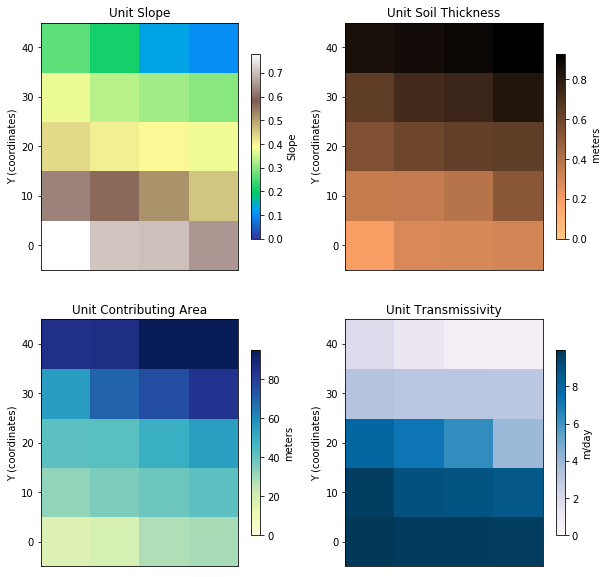

In [27]:
fields=['topographic__slope','soil__thickness','topographic__specific_contributing_area','soil__transmissivity']
maxval=[unitgrid.at_node['topographic__slope'].max(),
        unitgrid.at_node['soil__thickness'].max(),
        unitgrid.at_node['topographic__specific_contributing_area'].max(),
        unitgrid.at_node['soil__transmissivity'].max(),]
subtitles=['Unit Slope','Unit Soil Thickness','Unit Contributing Area','Unit Transmissivity']
colors=['terrain','copper_r','YlGnBu','PuBu']
scalelabel=['Slope',' meters','meters','m/day']

pl.plot_landslide_4variables([221,222,223,224],
                          unitgrid,unitgrid,unitgrid,unitgrid,
                          fields,maxval,
                          subtitles,colors,scalelabel)

Can't get enough nitty gritty landslide component details?  

Uncomment the box below to review ALL the details of what each variable represents.  
(Close the window with the upper right [x] after viewing.)

In [28]:
#?LandslideProbability

# 2.0 Unit Test Parameter Initialization 

#### Specify Unit Defaults to Test Hydrologic Forcing Options (2 options) and  Distribution Methods (4 options)
Given unit input values for recharge `unit_R` (mm/day) and depth forcings  `unit_D` (meters), use the unit tests to initialize the parameters using the `LandslideProbability()` function. 

### 2.1 Calculate unit test default values for recharge and depth forcing variables given a unit value for relative wetness (rw=0.75)
These are two different options used for calculating relative wetness which is input to the Factor of Safety Equation.  The unit test has options for comparing the range of input parameters, and  `T` and `area`are inputs to the recharge option calculation of relative wetness.

The plot_landslides functions include `scenario_unit_explorer()` which solves for a unit recharge f(Transmissivity, Slope, Area) and unit depth f(soil thickness) given a uniform value of relative wetness. Using default unit parameters from the unit grid, a single seed for the random distributions, and rw=0.75, we can solve for a set of input hydrologic forcing parameters, and then use the unit hydrology to solve for a known probability of failure in the unit test. 

Recharge = ((rw * (T * theta )) / a)

Depth = hs - rw * hs

In [29]:
T = unitgrid['node']['soil__transmissivity']
theta = np.sin(np.arctan(unitgrid['node']['topographic__slope']))
hs = unitgrid['node']['soil__thickness'] 
a_unit = unitgrid['node']['topographic__specific_contributing_area']

#Select a test to compare R and D min/max bounds
rel_wet = 0.75
[unit_R,unit_D]=test.scenario_unit_explorer(rel_wet,unitgrid)

In [30]:
print("When RW = {value}, Unit Test Mean Depth to Water Table = {value2} m".format(value=0.75, value2=round(unit_D[2],2)))
print("When RW = {value}, Unit Test Mean Recharge = {value2} mm/day".format(value=0.75, value2=round(unit_R[2])))


When RW = 0.75, Unit Test Mean Depth to Water Table = 0.15 m
When RW = 0.75, Unit Test Mean Recharge = 80.0 mm/day


In [31]:
unit_R

[0.56254651276264811,
 343.12300357331122,
 80.155194361965002,
 94.686785875411147]

### 2.2 Number of iterations to run Monte Carlo simulation

The landslide component employes the infinite slope model to calculate factor-of-safety values using a Monte Carlo simulation approach, which randomly selects input values from parameter distributions. You can pick the number of iterations to run Monte Carlo simulations, but the unit default is 25 and landscape default is 250. The higher the number of iteration, the longer the program runs, but the more precise the probability of failure result becomes.<br /> 

In [32]:
n = 25

There are _four_ different options for providing recharge for the Monte Carlo simulation.  We provide each of these grouped with depth to water table and recharge options below by specifying option inputs (a statistical distribution per node and option parameters. <br /> 

 ### 2.3. Recharge and Depth Options - 'uniform' distribution 

In this option, we'll apply a uniform distribution of recharge and depth based on minimum and maximum recharge and depth values.  We will then instantiate the LandslideProbability component with these parameters, as well as the grid and number of iterations we specified above.  Instantiate creates an instance of a class.  (For example, the _iPhone_ is a class and _each phone_ is an instance.)

No outputs are generated by these commands as they are setting up the recharge and depth and instantiating the component.


In [33]:
distribution1 = 'uniform'
grid_r1 = test.test_build_grid_unitarea()
grid_d1 = test.test_build_grid_unitarea()

LS_prob1_r = LandslideProbability(grid_r1,number_of_iterations=n,
    groundwater__recharge_distribution=distribution1,
    groundwater__recharge_min_value=unit_R[0],
    groundwater__recharge_max_value=unit_R[1])

LS_prob1_d = LandslideProbability(grid_d1,number_of_iterations=n,
    groundwater__depth_distribution=distribution1,
    groundwater__depth_min_value=unit_D[0],
    groundwater__depth_max_value=unit_D[1])


### 2.4. Recharge and Depth Options - 'lognormal' distribution

In this option, we specify a lognormal distribution with a recharge and depth mean and standard deviation values.  We instantiate the LandslideProbabilty class to create a new object or 'instance' of the class/component LandslideProbability. So now we have created two instances.

In [34]:
distribution2 = 'lognormal'
grid_r2 = test.test_build_grid_unitarea()
grid_d2 = test.test_build_grid_unitarea()

LS_prob2_r = LandslideProbability(grid_r2,number_of_iterations=n,
    groundwater__recharge_distribution=distribution2,
    groundwater__recharge_mean=unit_R[2],
    groundwater__recharge_standard_deviation=unit_R[3])

LS_prob2_d = LandslideProbability(grid_d2,number_of_iterations=n,
    groundwater__depth_distribution=distribution2,
    groundwater__depth_mean=unit_D[2],
    groundwater__depth_standard_deviation=unit_D[3])

### 2.5. Recharge and Depth Options - 'lognormal_spatial' distribution

Similar to the previous option (#2), we use a lognormal distribution for recharge and depth.  However, in this case we provide arrays to represent mean and standard deviation values for each node in our grid.  Thus, the distribution varies for each node - representing a spatially varying distribution of recharge and depth.

In [35]:
distribution3 = 'lognormal_spatial'
grid_r3 = test.test_build_grid_unitarea()
grid_d3 = test.test_build_grid_unitarea()

Remean3 = np.random.uniform(unit_R[0],unit_R[1],gridnum)
Restandard_deviation3 = np.random.rand(gridnum)
LS_prob3_r = LandslideProbability(grid_r3,number_of_iterations=n,
    groundwater__recharge_distribution=distribution3,
    groundwater__recharge_mean=Remean3,
    groundwater__recharge_standard_deviation=Restandard_deviation3)

Demean3 = np.random.uniform(unit_D[0],unit_D[1],gridnum)
Destandard_deviation3 = np.random.rand(gridnum)
LS_prob3_d = LandslideProbability(grid_d3,number_of_iterations=n,
    groundwater__depth_distribution=distribution3,
    groundwater__depth_mean=Demean3,
    groundwater__depth_standard_deviation=Destandard_deviation3)


### 2.6. Recharge and Depth 'data_driven_spatial' distributions 

### 2.6.1 Generate Recharge input option 

This is the most complex representation of recharge used in the LandslideProbability component.  
In this case, we provide recharge distributions (arrays) directly that are unique for each node.  

In a real-world situation, we would acquire these from a hydrologic model that often has a coarser resolution than our grid.<br />
Thus, we route the recharge data arrays from these larger Hydraulic Source Domain (HSD) grids down to each node of our grid. Landlab has a 'Source tracking algorithm' utility that performs this routing and produces Python dictionaries (_key: value_ pairs) that become parameters for the 'data_driven_spatial' recharge distribution.  In this synthetic example, we'll generate synthetic versions of these dictionaries.

In [36]:
HSD_dict = {}
for vkey in range(2,8):  #the first example vkey =2 is printed below
    HSD_dict[vkey] = np.random.uniform(unit_R[0],unit_R[1],10)    # 20 - 120 mm/day 
print('HSD_dict dictionary is a unique array of recharge provided as arrays (‘values’) for each of the Hydrologic Source Domain (HSD) (‘keys’). ')    
print('The entire synthetic dictionary is:')
print(HSD_dict)
print('The array for the HSD vkey = 2 of this unordered dictionary is:')
print(HSD_dict[2])

HSD_dict dictionary is a unique array of recharge provided as arrays (‘values’) for each of the Hydrologic Source Domain (HSD) (‘keys’). 
The entire synthetic dictionary is:
{2: array([ 188.56435126,  245.55814274,  207.04544412,  187.21797872,
        145.68992821,  221.8203291 ,  150.46262161,  306.04871325,
        330.6753022 ,  131.91444846]), 3: array([ 271.77623742,  181.74103196,  195.15215099,  317.63535398,
         24.89669108,   30.40959924,    7.48856998,  285.78518136,
        267.12827878,  298.59430566]), 4: array([ 335.79849312,  274.32266953,  158.64712777,  267.94097789,
         41.0786879 ,  219.77418406,   49.66971417,  324.16876251,
        179.32714613,  142.6093302 ]), 5: array([  91.18883791,  265.78439304,  156.82161281,  195.28553985,
          6.99918914,  212.14004469,  210.24233705,  211.89973846,
        323.85331964,  234.12721981]), 6: array([ 123.71573725,  150.27241236,  239.54340785,   21.1934116 ,
        228.97045731,  230.29656165,   72.63129279,

***Note: this is a much lower recharge than the uniform.

HSD_ID dictionary has the grid node ID as ‘keys’ and HSD IDs in a list as ‘values’. 

In [37]:
HSD_id_dict = {}
for ckey in unitgrid.core_nodes:
    HSD_id_dict[ckey] = np.random.randint(2,8,2)
print('The entire ID synthetic dictionary is:')
print(HSD_id_dict)
print('The array for the ckey = 5, the first index of core nodes in the dictionary is:')
print(HSD_id_dict[5])
print('The two values in the array are the multiple vkeys that correspond/drain to the ckey:')


The entire ID synthetic dictionary is:
{5: array([7, 7]), 6: array([7, 2]), 9: array([3, 7]), 10: array([3, 5]), 13: array([2, 7]), 14: array([2, 3])}
The array for the ckey = 5, the first index of core nodes in the dictionary is:
[7 7]
The two values in the array are the multiple vkeys that correspond/drain to the ckey:


The fractions dictionary assigns to each node ID as ‘key’ a lists the fractions of each HSD draining to the node as ‘values’. 

In [38]:
fract_dict = {}
for ckey in unitgrid.core_nodes:
    fract_dict[ckey] =  np.random.rand(2)
print('The entire ID synthetic dictionary is:')
print(fract_dict)
print('The fractional values (sum=1) in the array can be used to add the multiple vkeys that correspond/drain to each key:')
print(fract_dict[5])

The entire ID synthetic dictionary is:
{5: array([ 0.83794491,  0.09609841]), 6: array([ 0.97645947,  0.4686512 ]), 9: array([ 0.97676109,  0.60484552]), 10: array([ 0.73926358,  0.03918779]), 13: array([ 0.28280696,  0.12019656]), 14: array([ 0.2961402 ,  0.11872772])}
The fractional values (sum=1) in the array can be used to add the multiple vkeys that correspond/drain to each key:
[ 0.83794491  0.09609841]


In [39]:
#HSD_inputs_r

When the component is instantiated, the three dictionaries are provided as the 'parameters' for the distribution in explicit order.

### 2.6.2 Generate Depth to water table Input option

In [40]:
key=np.arange(unitgrid.number_of_nodes)
HSD_inputs_d={}

for i in range(unitgrid.number_of_nodes):
    annualmaxDWT=np.random.uniform(unit_D[0],unit_D[1],10)
    HSD_inputs_d[i] = (annualmaxDWT)

#print(HSD_inputs_d)
print('The values assigned to the first node (key) are: ')
print(HSD_inputs_d[0])

The values assigned to the first node (key) are: 
[ 0.10767074  0.1252196   0.06140426  0.17592861  0.15298624  0.09808452
  0.14508424  0.06683461  0.15468956  0.21909439]


### Data driven spatially distributed landslide component input distributions

In [41]:
distribution4 = 'data_driven_spatial'
grid_r4 = test.test_build_grid_unitarea()
grid_d4 = test.test_build_grid_unitarea()

HSD_inputs_r = [HSD_dict,HSD_id_dict,fract_dict]
LS_prob4_r = LandslideProbability(grid_r4,number_of_iterations=n,
    groundwater__recharge_distribution=distribution4,
    groundwater__recharge_HSD_inputs=HSD_inputs_r)

LS_prob4_d = LandslideProbability(grid_d4,number_of_iterations=n,
    groundwater__depth_distribution=distribution4,
    groundwater__depth_HSD_inputs=HSD_inputs_d)


## 3.0 Test the Landslide Component Options
Given unit input values for recharge `unit_R` (mm/day) and depth forcings  `unit_D` (meters), use the unit tests to solve for `landslide__probability of failure`.  

There are 8 combinations of hydrologic forcing and statistical distribution method.  **Unit Tests** for Landslide Probability calculations using four variations of statistical and data generated forcings for recharge and depth.  Since recharge defaults are a function of specific contributing area, we suggest running **Unit Area Tests** for each grid used in a model configuration. 

To generate the landslide component outputs, we call the `calculate_landslide_probability` method from within the `test_calculate_landslide_probability_uniform_depth_method()` (for example) with an output of the component in the form using the class instance (e.g., LS_prob_test_d1) for each option specified above. 

To verify results of the unit test, and the core node values comparing unit test defaults and the final assertions, we use `print_failure_nodevalues()` and 
`print_testcore_nodevalues()`

**T13: Run the test `test_calculate_landslide_probability_uniform_depth_method()`**
 

In [42]:
LS_prob_test_d1=test.test_calculate_landslide_probability_uniform_depth_method()

In [43]:
grid_test_d1=LS_prob_test_d1.grid
print("Unit test core node 6 = {value}".format(value=grid_test_d1.at_node["landslide__probability_of_failure"][5]))
print("Unit test core node 10 = {value}".format(value=grid_test_d1.at_node["landslide__probability_of_failure"][9]))

Unit test core node 6 = 0.8
Unit test core node 10 = 0.48


**T14: Run the test 
`test_calculate_landslide_probability_uniform_recharge_method()`**

In [44]:
LS_prob_test_r1=test.test_calculate_landslide_probability_uniform_recharge_method()
grid_test_r1=LS_prob_test_r1.grid
test.print_failure_nodevalues(LS_prob_test_r1)
test.print_testcore_nodevalues(LS_prob_test_r1)

Ouput Failure: landslide__probability_of_failure value calculated for each node:
[ 0.    0.    0.    0.    0.    0.96  0.88  0.    0.    0.84  0.68  0.
  0.    0.48  0.    0.    0.    0.    0.    0.  ]

Unit test core node 6 = 0.96
Unit test core node 10 = 0.84


**T15: Run the test 
`test_calculate_landslide_probability_lognormal_depth_method()`**

In [45]:
LS_prob_test_d2=test.test_calculate_landslide_probability_lognormal_depth_method()
grid_test_d2=LS_prob_test_d2.grid
test.print_failure_nodevalues(LS_prob_test_d2)
test.print_testcore_nodevalues(LS_prob_test_d2)

Ouput Failure: landslide__probability_of_failure value calculated for each node:
[ 0.    0.    0.    0.    0.    0.88  0.84  0.    0.    0.32  0.08  0.
  0.    0.    0.    0.    0.    0.    0.    0.  ]

Unit test core node 6 = 0.88
Unit test core node 10 = 0.32


**T16: Run the test 
`test_calculate_landslide_probability_lognormal_recharge_method()`**

In [46]:
LS_prob_test_r2=test.test_calculate_landslide_probability_lognormal_recharge_method()
grid_test_r2=LS_prob_test_r2.grid
test.print_failure_nodevalues(LS_prob_test_r2)
test.print_testcore_nodevalues(LS_prob_test_r2)

Ouput Failure: landslide__probability_of_failure value calculated for each node:
[ 0.    0.    0.    0.    0.    1.    0.96  0.    0.    0.8   0.88  0.
  0.    0.04  0.    0.    0.    0.    0.    0.  ]

Unit test core node 6 = 1.0
Unit test core node 10 = 0.8


**T17: Run the test 
`test_calculate_landslide_probability_lognormal_spatial_depth_method()`**

In [47]:
LS_prob_test_d3=test.test_calculate_landslide_probability_lognormal_spatial_depth_method()
grid_test_d3=LS_prob_test_d3.grid
test.print_failure_nodevalues(LS_prob_test_d3)
test.print_testcore_nodevalues(LS_prob_test_d3)

Ouput Failure: landslide__probability_of_failure value calculated for each node:
[ 0.    0.    0.    0.    0.    0.88  0.88  0.    0.    0.96  0.92  0.
  0.    0.04  0.    0.    0.    0.    0.    0.  ]

Unit test core node 6 = 0.88
Unit test core node 10 = 0.96


**T18: Run the test 
`test_calculate_landslide_probability_lognormal_spatial_recharge_method()`**

In [48]:
LS_prob3_r_unit=test.test_calculate_landslide_probability_lognormal_spatial_recharge_method()
grid_test_r3=LS_prob3_r_unit.grid
test.print_failure_nodevalues(LS_prob3_r_unit)
test.print_testcore_nodevalues(LS_prob3_r_unit)

Ouput Failure: landslide__probability_of_failure value calculated for each node:
[ 0.    0.    0.    0.    0.    1.    1.    0.    0.    0.24  0.48  0.
  0.    0.    0.    0.    0.    0.    0.    0.  ]

Unit test core node 6 = 1.0
Unit test core node 10 = 0.24


**T19: Run the test 
`test_calculate_landslide_probability_datadriven_spatial_depth_method()`**

**Use Unit Test function** to calculate data driven spatial failure probability with two methods (depth, recharge)

In [49]:
LS_prob_test_d4=test.test_calculate_landslide_probability_datadriven_spatial_depth_method()
grid_test_d4=LS_prob_test_d4.grid
print("Depth Hydrologic Forcing")
test.print_failure_nodevalues(LS_prob_test_d4)
test.print_testcore_nodevalues(LS_prob_test_d4)

Depth Hydrologic Forcing
Ouput Failure: landslide__probability_of_failure value calculated for each node:
[ 0.    0.    0.    0.    0.    0.92  1.    0.    0.    0.    0.08  0.
  0.    0.    0.    0.    0.    0.    0.    0.  ]

Unit test core node 6 = 0.92
Unit test core node 10 = 0.0


**T20: Run the test 
`test_calculate_landslide_probability_datadriven_spatial_recharge_method()`**

In [50]:
LS_prob_test_r4=test.test_calculate_landslide_probability_datadriven_spatial_recharge_method()
grid_test_r4=LS_prob_test_r4.grid
print("Recharge Hydrologic Forcing")
test.print_failure_nodevalues(LS_prob_test_r4)
test.print_testcore_nodevalues(LS_prob_test_r4)

Recharge Hydrologic Forcing
Ouput Failure: landslide__probability_of_failure value calculated for each node:
[ 0.    0.    0.    0.    0.    1.    0.96  0.    0.    0.84  0.8   0.
  0.    0.04  0.04  0.    0.    0.    0.    0.  ]

Unit test core node 6 = 1.0
Unit test core node 10 = 0.84


# 4.0 Plot Unit Tests

## 4.1 Landslide Component Unit Test Outputs
### Uniform-Depth

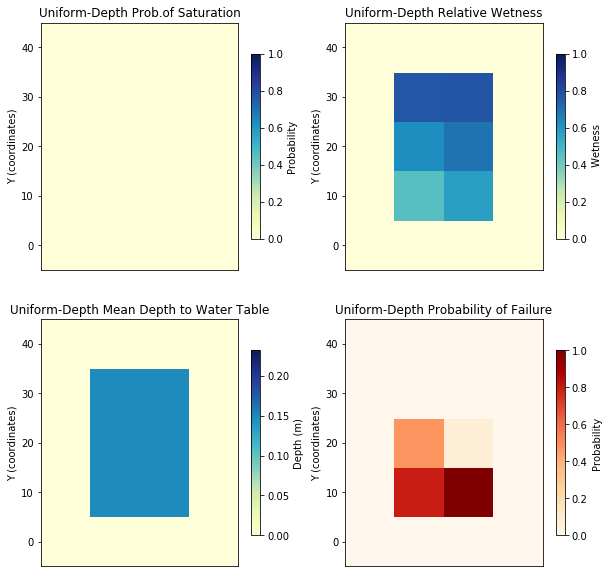

In [51]:
fields=['soil__probability_of_saturation','soil__mean_relative_wetness','soil__mean_watertable_depth','landslide__probability_of_failure']
maxval=[1,1, unit_D[1],1,]
colors=['YlGnBu','YlGnBu','YlGnBu','OrRd']
scalelabel=['Probability',' Wetness','Depth (m)','Probability']
subtitle=['Prob.of Saturation','Relative Wetness','Mean Depth to Water Table','Probability of Failure']
smashtitle=subtitle
pgrid = grid_test_d1
ptitle = "Uniform-Depth %s"
for s in subtitle: smashtitle[subtitle.index(s)]="".join(ptitle % (s))
    
pl.plot_landslide_4variables([221,222,223,224],
                          pgrid,pgrid,pgrid,pgrid,
                          fields,maxval,
                          smashtitle,colors,scalelabel)


### Uniform-Recharge
Recharge outputs are in meters (m), here we convert the recharge to mm/day and add to the grid. 

In [52]:
print(unit_R)
recharge_mm_per_m=1000
grid_test_r1.at_node['soil__mean_recharge_mm']=recharge_mm_per_m * grid_test_r1.at_node['soil__mean_recharge']

[0.56254651276264811, 343.12300357331122, 80.155194361965002, 94.686785875411147]


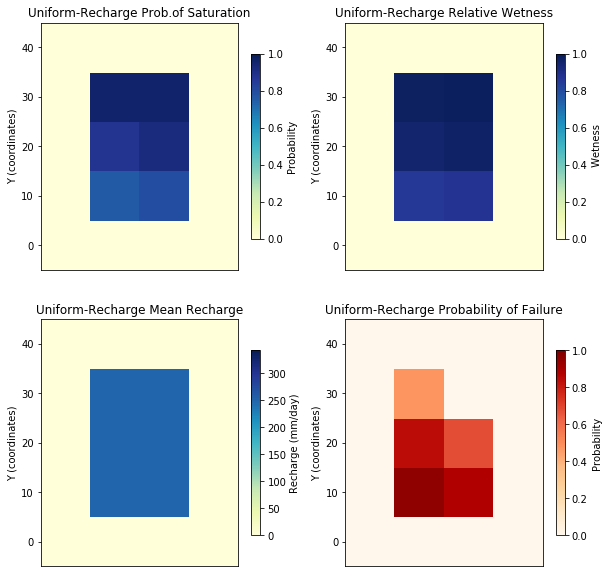

In [53]:
fields=['soil__probability_of_saturation','soil__mean_relative_wetness','soil__mean_recharge_mm','landslide__probability_of_failure']
maxval=[1,1, unit_R[1],1,]
colors=['YlGnBu','YlGnBu','YlGnBu','OrRd']
scalelabel=['Probability',' Wetness','Recharge (mm/day)','Probability']
subtitle=['Prob.of Saturation','Relative Wetness','Mean Recharge','Probability of Failure']
smashtitle=subtitle
pgrid = grid_test_d1
ptitle = "Uniform-Recharge %s"
for s in subtitle: smashtitle[subtitle.index(s)]="".join(ptitle % (s))
    
pl.plot_landslide_4variables([221,222,223,224],
                          grid_test_r1,grid_test_r1,grid_test_r1,grid_test_r1,
                          fields,maxval,
                          smashtitle,colors,scalelabel)

## 4.2 Landslide Component Unit Test Outputs
### Data Driven Spatial- Depth

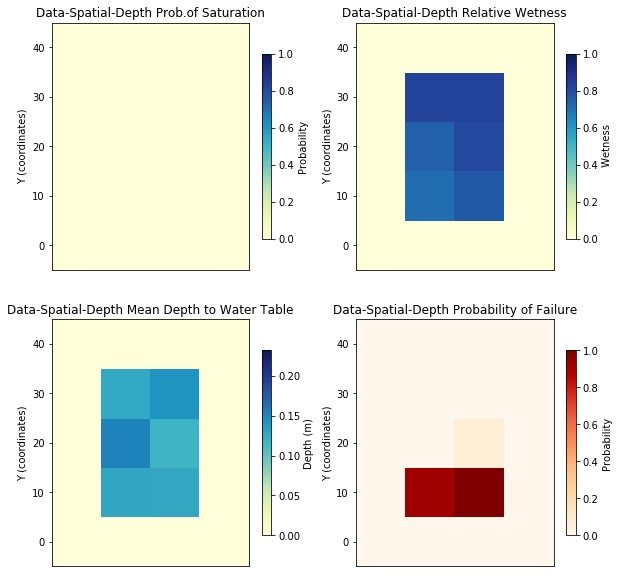

In [54]:
fields=['soil__probability_of_saturation','soil__mean_relative_wetness','soil__mean_watertable_depth','landslide__probability_of_failure']
maxval=[1,1, unit_D[1],1,]
colors=['YlGnBu','YlGnBu','YlGnBu','OrRd']
scalelabel=['Probability',' Wetness','Depth (m)','Probability']
subtitle=['Prob.of Saturation','Relative Wetness','Mean Depth to Water Table','Probability of Failure']
smashtitle=subtitle
pgrid = grid_test_d4
ptitle = "Data-Spatial-Depth %s"
for s in subtitle: smashtitle[subtitle.index(s)]="".join(ptitle % (s))
    
pl.plot_landslide_4variables([221,222,223,224],
                          pgrid,pgrid,pgrid,pgrid,
                          fields,maxval,
                          smashtitle,colors,scalelabel)


### Data Driven Spatial- Recharge
Recharge outputs are in meters (m), here we convert the recharge to mm/day and add to the grid. 

In [55]:
print(unit_R)
recharge_mm_per_m=1000
grid_test_r4.at_node['soil__mean_recharge_mm']=recharge_mm_per_m * grid_test_r4.at_node['soil__mean_recharge']

[0.56254651276264811, 343.12300357331122, 80.155194361965002, 94.686785875411147]


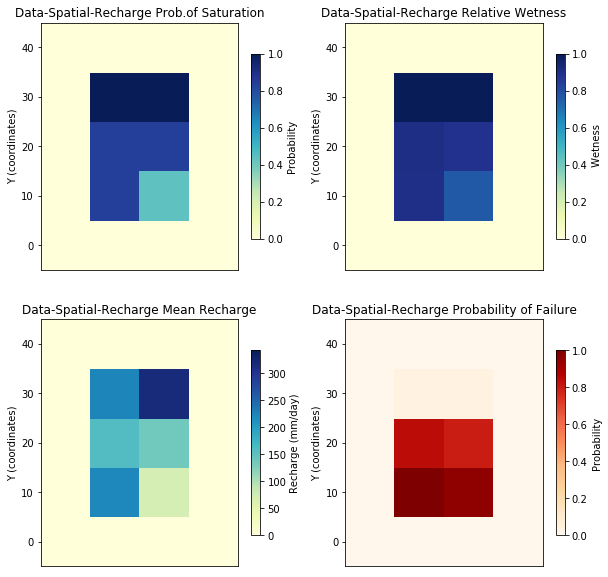

In [56]:
fields=['soil__probability_of_saturation','soil__mean_relative_wetness','soil__mean_recharge_mm','landslide__probability_of_failure']
maxval=[1,1, unit_R[1],1,]
colors=['YlGnBu','YlGnBu','YlGnBu','OrRd']
scalelabel=['Probability',' Wetness','Recharge (mm/day)','Probability']
subtitle=['Prob.of Saturation','Relative Wetness','Mean Recharge','Probability of Failure']
smashtitle=subtitle
pgrid = grid_test_r4
ptitle = "Data-Spatial-Recharge %s"
for s in subtitle: smashtitle[subtitle.index(s)]="".join(ptitle % (s))
    
pl.plot_landslide_4variables([221,222,223,224],
                          pgrid,pgrid,pgrid,pgrid,
                          fields,maxval,
                          smashtitle,colors,scalelabel)

## 4.3 Landslide Component Unit Test Outputs: Probability of Failure 
### Unit default landslide parameters; hydrologic forcings with four statistical distribution methods

### Depth to groundwater

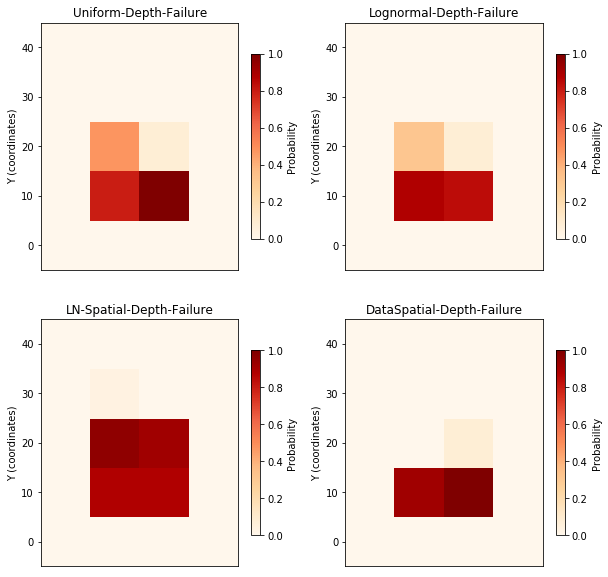

In [57]:
fields=['landslide__probability_of_failure','landslide__probability_of_failure','landslide__probability_of_failure','landslide__probability_of_failure']
maxval=[1,1,1,1,]
subtitles=['Uniform-Depth-Failure','Lognormal-Depth-Failure','LN-Spatial-Depth-Failure','DataSpatial-Depth-Failure']
colors=['OrRd','OrRd','OrRd','OrRd']
scalelabel=['Probability','Probability','Probability','Probability']

pl.plot_landslide_4variables([221,222,223,224],
                          grid_test_d1,grid_test_d2,grid_test_d3,grid_test_d4,
                          fields,maxval,
                          subtitles,colors,scalelabel)

### Unit default landslide parameters; hydrologic forcings with four statistical distribution methods

### Recharge

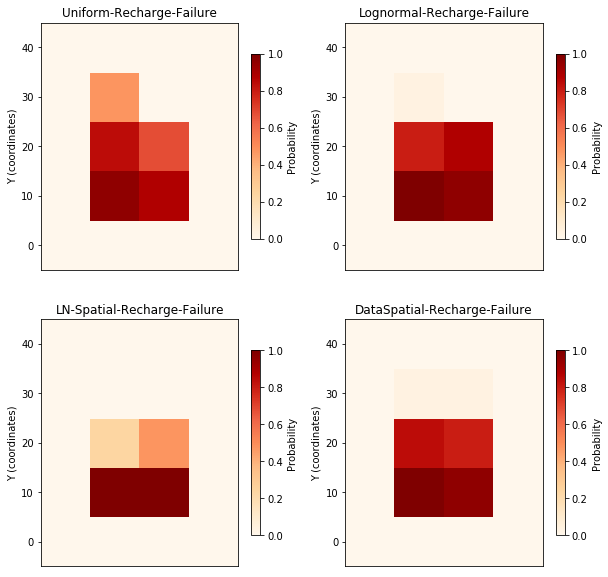

In [58]:
fields=['landslide__probability_of_failure','landslide__probability_of_failure','landslide__probability_of_failure','landslide__probability_of_failure']
maxval=[1,1,1,1,]
subtitles=['Uniform-Recharge-Failure','Lognormal-Recharge-Failure','LN-Spatial-Recharge-Failure','DataSpatial-Recharge-Failure']
colors=['OrRd','OrRd','OrRd','OrRd']
scalelabel=['Probability','Probability','Probability','Probability']

pl.plot_landslide_4variables([221,222,223,224],
                          grid_test_r1,grid_test_r2,grid_test_r3,grid_test_r4,
                          fields,maxval,
                          subtitles,colors,scalelabel)

## 4.4 Run Landslide Component 
This is helpful to demonstrate and verify the difference between running a model unit test (results are static) and running the model with random variables introduced in each model instance of executing `calculate_landslide_probability()`

**Use Landslide Component** to calculate data driven spatial failure probability with two methods (depth, recharge) **different results are expected each time this is run**

In [59]:
print("Recharge Hydrologic Forcing")
LS_prob4_r.calculate_landslide_probability()
test.print_list_nodevalues(LS_prob4_r,["landslide__probability_of_failure"])
test.print_failure_nodevalues(LS_prob4_r)
print("Depth Hydrologic Forcing")
LS_prob4_d.calculate_landslide_probability()
test.print_list_nodevalues(LS_prob4_d,["landslide__probability_of_failure"])
test.print_failure_nodevalues(LS_prob4_d)

Recharge Hydrologic Forcing
Input: (Min, Max) range of default landslide__probability_of_failure model inputs: (0, 1)
Ouput: landslide__probability_of_failure default value initialized for each node:
[ 0.    0.    0.    0.    0.    1.    1.    0.    0.    0.92  0.8   0.
  0.    0.56  0.    0.    0.    0.    0.    0.  ]

Ouput Failure: landslide__probability_of_failure value calculated for each node:
[ 0.    0.    0.    0.    0.    1.    1.    0.    0.    0.92  0.8   0.
  0.    0.56  0.    0.    0.    0.    0.    0.  ]

Depth Hydrologic Forcing
Input: (Min, Max) range of default landslide__probability_of_failure model inputs: (0, 1)
Ouput: landslide__probability_of_failure default value initialized for each node:
[ 0.    0.    0.    0.    0.    0.24  0.6   0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.  ]

Ouput Failure: landslide__probability_of_failure value calculated for each node:
[ 0.    0.    0.    0.    0.    0.24  0.6   0.    0.    0.    0.    0.
  0.

# 5.0  Testing the unit tests with pytest

Usually you can run your components tests only (as opposed to the entire repository) with

`pytest */componet/name_of_component`

this tests the files in landlab and in tests.

Since we have tests that are in notebooks  (this one) and the default behavior of pytest has been configured to ignore the notebooks, we run

`pytest --run-notebook`

in the Anaconda terminal prompt.

## Citing Landlab Landslide Component

**If you use any portion of Landlab, you must cite the following papers:**

Hobley, D. E. J., Adams, J. M., Nudurupati, S. S., Hutton, E. W. H., Gasparini, N. M., Istanbulluoglu, E. and Tucker, G. E., 2017, Creative computing with Landlab: an open-source toolkit for building, coupling, and exploring two-dimensional numerical models of Earth-surface dynamics, Earth Surface Dynamics, 5, p 21-46, 10.5194/esurf-5-21-2017.

Barnhart, K. R., Hutton, E. W. H., Tucker, G. E., Gasparini, N. M., Istanbulluoglu, E., Hobley, D. E. J., Lyons, N. J., Mouchene, M., Nudurupati, S. S., Adams, J. M., and Bandaragoda, C.: Short communication: Landlab v2.0: A software package for Earth surface dynamics, Earth Surf. Dynam. Discuss., https://doi.org/10.5194/esurf-2020-12, in review, 2020.
                
**If you use any portion of the Landlab Landslide Component, you must cite the following paper:**
Strauch, R., Istanbulluoglu, E., Nudurupati, S.S., Bandaragoda, C., Gasparini, N.M. and Tucker, G.E., 2018. A hydroclimatological approach to predicting regional landslide probability using Landlab. Earth Surface Dynamics, 6(1), pp.49-49.

<img src="https://www.washington.edu/brand/files/2014/09/W-Logo_Purple_Hex.png" style="float:right;width:150px;padding:20px">   


The development of this Notebook has been made possible by the Landlab project funded by the National Science Foundation (OAC 1450338 to N. Gasparini, OAC 1450409 to G. Tucker, OAC 1450412 to E. Istanbulluoglu).

We acknowledge that this research takes place in the ancestral homelands of Tribes, Bands, and First Nations, including most notably the Upper Skagit Indian Tribe, Sauk-Suiattle Indian Tribe, Swinomish Indian Tribal Community, Samish Indian Nation, Nooksack Tribe, Lummi Nation, Stó:lō Nation, Nlaka’pamux Nation, Colville Confederated Tribes, Syilx/Okanagan Nation.  The University of Washington acknowledges the Coast Salish peoples of this land, the land which touches the shared waters of all tribes and bands within the Suquamish, Tulalip and Muckleshoot nations.


<hr>
<small>For more Landlab tutorials, click here: <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html</a></small>
<hr>